In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import os 
from glob import glob
import pickle

import numpy as np
import cv2

import albumentations

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset

from tensorboardX import SummaryWriter

In [4]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs
from src.utils import tbx_logger as tbx

from src.modules import dataset as ds
from src.modules import metrics as ms
from src.modules import augmentations as augs
from src.modules import learner as lrn
from src.modules import lr_scheduler as lrs

# from retinanet import model as retinanet
import src.models.retinanet.resnext
import src.models.retinanet.model
from src.models.retinanet import model as retinanet

%load_ext autoreload
%autoreload 2

In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
model_name = 'retinanet18/fold_4_checkpoint.epoch_81'
checkpoint = os.path.join(config.PATHS.MODELS, model_name)
paths = os.path.join(config.PATHS.IMAGES, '*.jpg')
fold = [os.path.basename(path) for path in glob(paths)]

In [7]:
dataset = ds.BBoxDataset(fold, labels=None)

In [8]:
model = retinanet.resnet18(num_classes=2, focal_loss=None, pretrained=True, single_channel=True, make_clf=False)
model = lrn.get_model(model, checkpoint=checkpoint, devices=config.PARAMS.CUDA_DEVICES)
learner = lrn.RetinaLearner(model)

Overlapped keys: 100
Poped keys: []
Summed over: weight
Overlapped keys: 156


In [9]:
datagen = DataLoader(dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=False, collate_fn=ds.bbox_collater)

In [10]:
predictions = learner.validate(datagen)

  0%|          | 0/891 [00:00<?, ?it/s]/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 891/891 [00:20<00:00, 43.23it/s]


In [11]:
def _extract_meta(el, threshold=config.PARAMS.THRESHOLD):
    scores = el['scores'].data.numpy()
    labels = el['class'].data.numpy()
    bboxes = el['anchors'].data.numpy()
    
    annotation = el['annotation'] if 'annotation' in el else None

    bboxes = np.concatenate([
        bboxes, 
        np.expand_dims(labels, -1),
    ], -1)
    bboxes = bboxes[scores > threshold].astype(np.uint)
    scores = scores[scores > threshold]

    return annotation, bboxes, scores

In [12]:
df = pd.DataFrame()
data = list()
for idx, el in enumerate(predictions):
    _, bboxes, scores = _extract_meta(el)
    for i, bbox in enumerate(bboxes):
        data.append({
            'filename': el['pid'], 
            'bboxes': ' '.join(bbox[:-1].astype(np.str)), 
            'is_normal': bbox[-1], 
            'scores': scores[i],
        })
data = pd.DataFrame(data)
formatted = '_'.join(os.path.split(model_name))
path = os.path.join(config.PATHS.CSV, 'checkpoint_{}.csv'.format(formatted))
data.to_csv(path, index=False)
data.head()

,bboxes,filename,is_normal,scores
0,186 219 226 241,img_01088.jpg,1,0.912377
1,175 192 214 211,img_01088.jpg,1,0.906229
2,203 249 243 271,img_01088.jpg,1,0.666412
3,228 341 277 364,img_01088.jpg,1,0.648484
4,170 164 209 183,img_01088.jpg,1,0.624006


In [13]:
colours = {
    1: (255, 255, 255), 
    0: (255, 150, 150), 
}


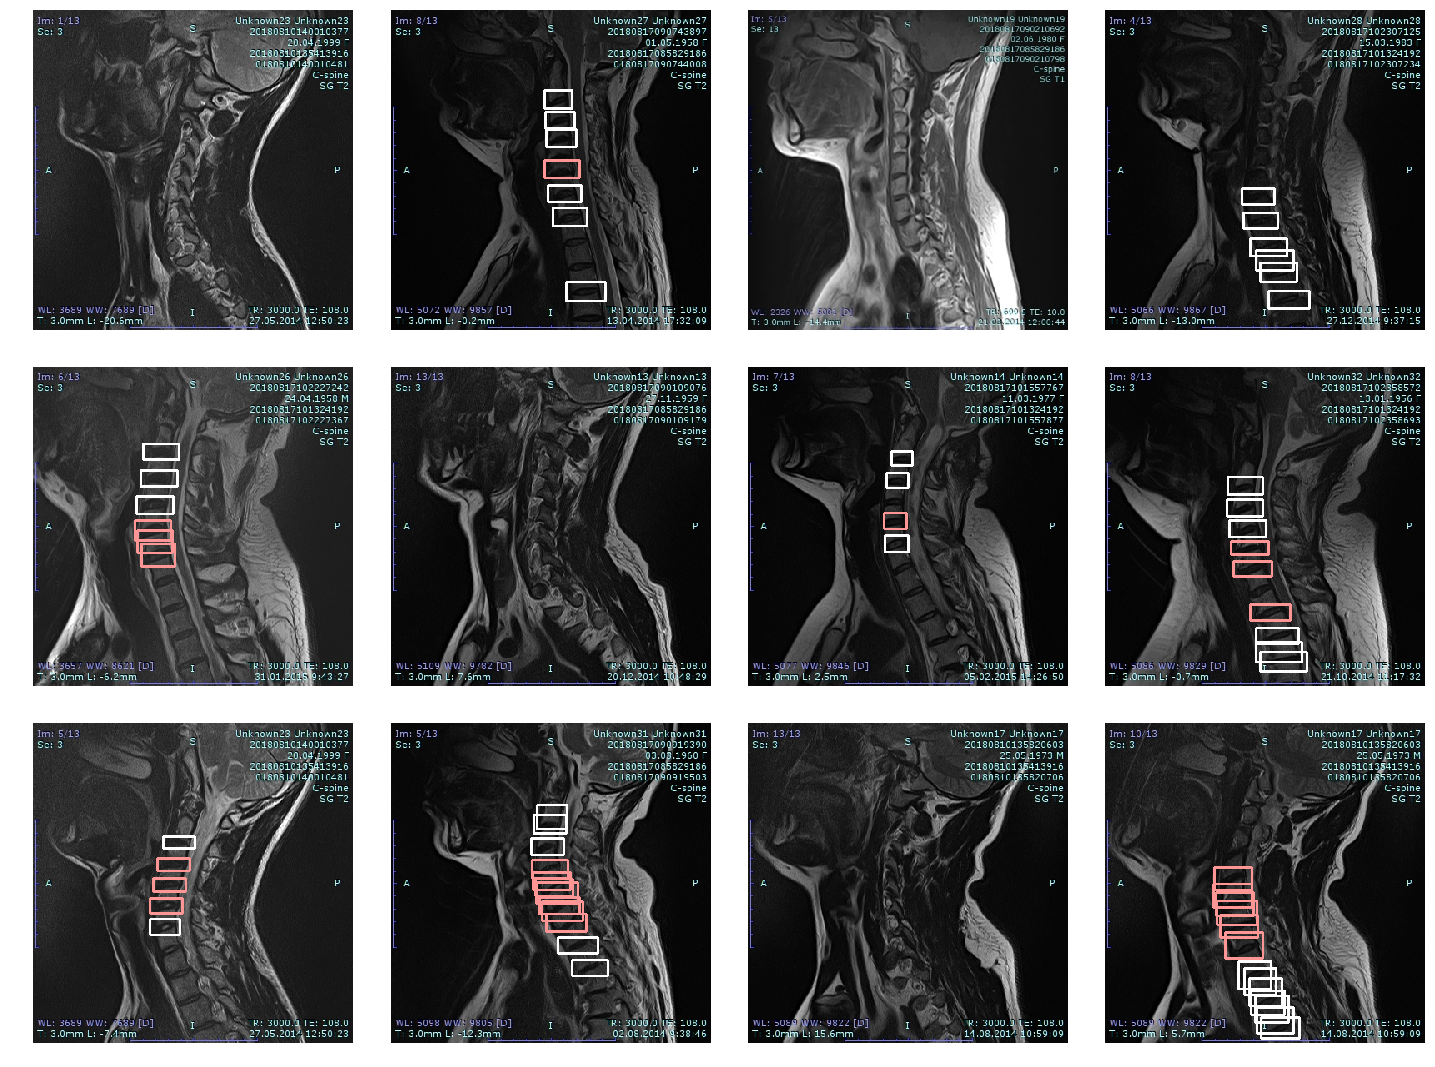

In [15]:
infer_ids = np.random.randint(len(predictions), size=12)
fig, axes = plt.subplots(len(infer_ids) // 4, 4, figsize=(20, len(infer_ids) // 4 * 5))

for i, idx in enumerate(infer_ids):
    el = predictions[idx]
    filename = el['pid']
    image = cv2.imread(os.path.join(config.PATHS.IMAGES, filename))

    _, bboxes, scores = _extract_meta(el)
    for bbox in bboxes:
        image = vs.visualize_bbox(image, bbox, colour=colours, thickness=1)
    axes[i // 4][i % 4].imshow(image)
    axes[i // 4][i % 4].axis('off')

fig.tight_layout()
plt.show()